In [1]:
from casatasks import listobs
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import numpy as np

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from photutils.segmentation import detect_sources, SourceCatalog
from astropy.wcs import WCS
from photutils import EllipticalAperture, aperture_photometry
import pandas as pd

from astropy.visualization import make_lupton_rgb
from skimage.measure import find_contours
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, FancyArrowPatch

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

/var/folders/vw/tpd43dxn2jb6bgwqw2fs0y7r0000gn/T/ipykernel_79137/438156016.py:11: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
/var/folders/vw/tpd43dxn2jb6bgwqw2fs0y7r0000gn/T/ipykernel_79137/438156016.py:11: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


In [2]:
#listobs(vis='NGC_5995.ms', verbose=True, listfile='NGC_5995_listobs.txt', overwrite=True);

In [3]:
data=pd.read_csv('file.tsv',sep='\t')

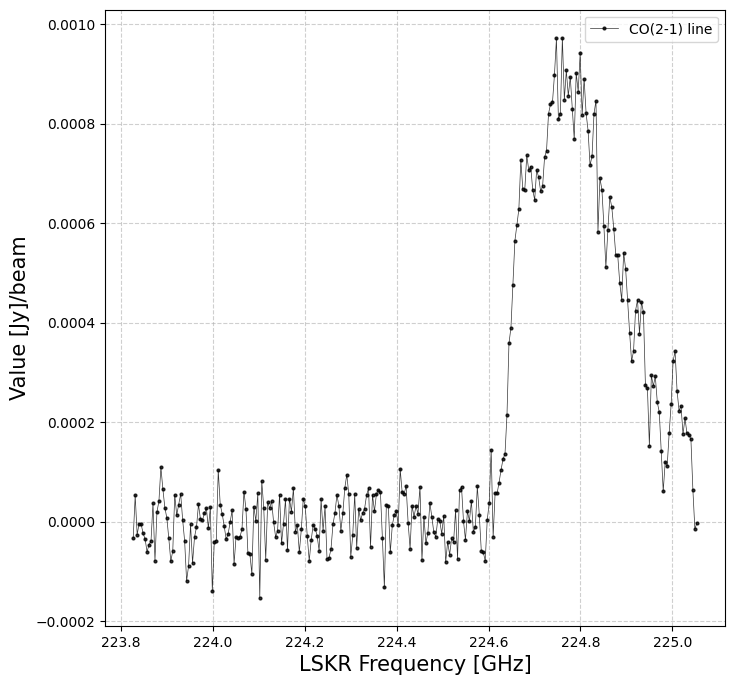

In [4]:
# Hacer un plot de data: Corresponde al espectro de la línea detectada CO(2-0) en la galaxia NGC 5995
plt.figure(figsize=(8,8))
plt.plot(data['# x'],data['y'], label='CO(2-1) line', color='black', linewidth=0.5, alpha=0.8, marker='o', markersize=2, markerfacecolor='black', markeredgecolor='black')
plt.xlabel('LSKR Frequency [GHz]', fontsize=15)
plt.ylabel('Value [Jy]/beam', fontsize=15)
#plt.title('CO(2-0) line detected in NGC 5995')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

In [5]:
pi = np.pi
bmin = 0.285812
bmaj = 0.439447

def calculate_beam_area(bmin=bmin, bmaj=bmaj):
    return pi*bmin*bmaj/(4*np.log(2))


def flux_and_rms(sum, rms, num_pix_apertura):
    bmin = 0.285812
    bmaj = 0.439447
    beam_area = calculate_beam_area(bmin, bmaj)

    pixel_area = (0.05)**2
    beam_pixel_ratio = beam_area/pixel_area
    flux_density = sum/beam_pixel_ratio
    error = rms * (np.sqrt(num_pix_apertura/beam_pixel_ratio))
    return flux_density, error

    #print(f'The flux density is {flux_density} Jy/km.s')
    #print(f'The error is {error} Jy/km.s')

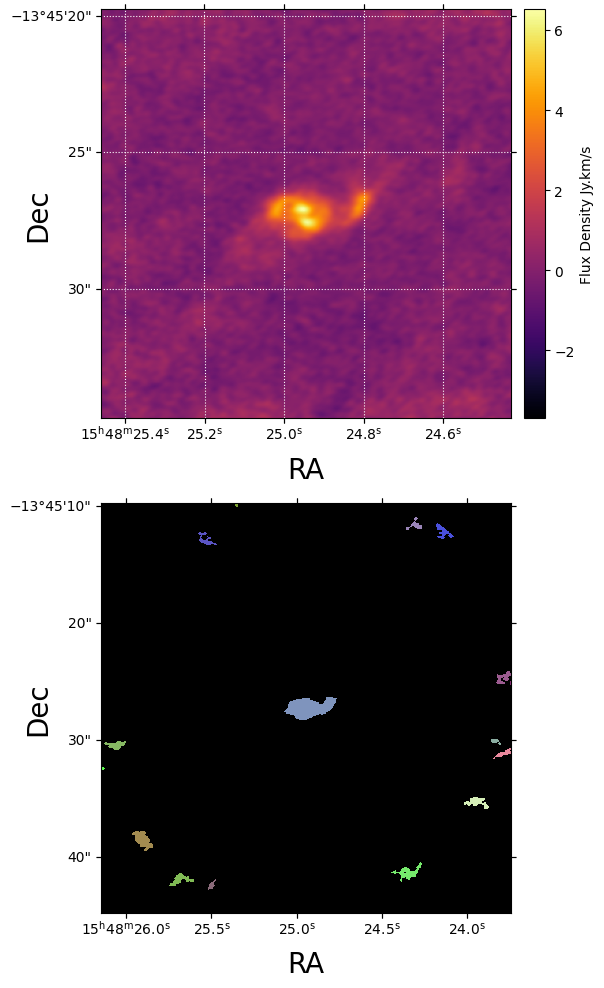

In [60]:
fits_files = fits.open('integrated_nt.fits')
header = fits_files[0].header
data = fits_files[0].data
data = data[0]

# Delete the nan values
data_nonan = data[~np.isnan(data)]
std_3 = np.std(data_nonan)

#mean, std, median = sigma_clipped_stats(data)
segm = detect_sources(data, 2*std_3, npixels=100)
wcs = WCS(header)

# Asume que las primeras dos dimensiones de WCS son RA y Dec. Ajusta esto si es diferente.
wcs_2d = wcs.celestial
# Configurar los ejes con WCS para la primera imagen
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(10, 10), subplot_kw={'projection': wcs_2d})

# Normalizar los datos
norm = simple_norm(data, 'linear', min_percent=1, max_percent=99)

# Mostrar la imagen con coordenadas WCS
ax2.imshow(data, origin='lower', cmap='inferno')
ax2.coords.grid(color='white', ls='dotted')
ax2.set_xlabel('RA', fontsize=20)
ax2.set_ylabel('Dec', fontsize=20, labelpad=-1)
ax2.set_xlim(300, 600)
ax2.set_ylim(300, 600)

# Configurar los ejes sin WCS para la imagen segmentada
ax3.imshow(segm.data, origin='lower', interpolation='nearest', cmap=segm.make_cmap(seed=1234))
ax3.set_xlabel('RA', fontsize=20)
ax3.set_ylabel('Dec', fontsize=20, labelpad=-1)
ax3.set_xlim(100, 800)
ax3.set_ylim(100, 800)

cax = inset_axes(ax2, width="5%", height="100%", loc='center right', bbox_to_anchor=(0.1, 0., 1, 1), bbox_transform=ax2.transAxes)
cbar = plt.colorbar(ax2.images[0], cax=cax, label='Flux Density Jy.km/s')

plt.tight_layout()
plt.show()


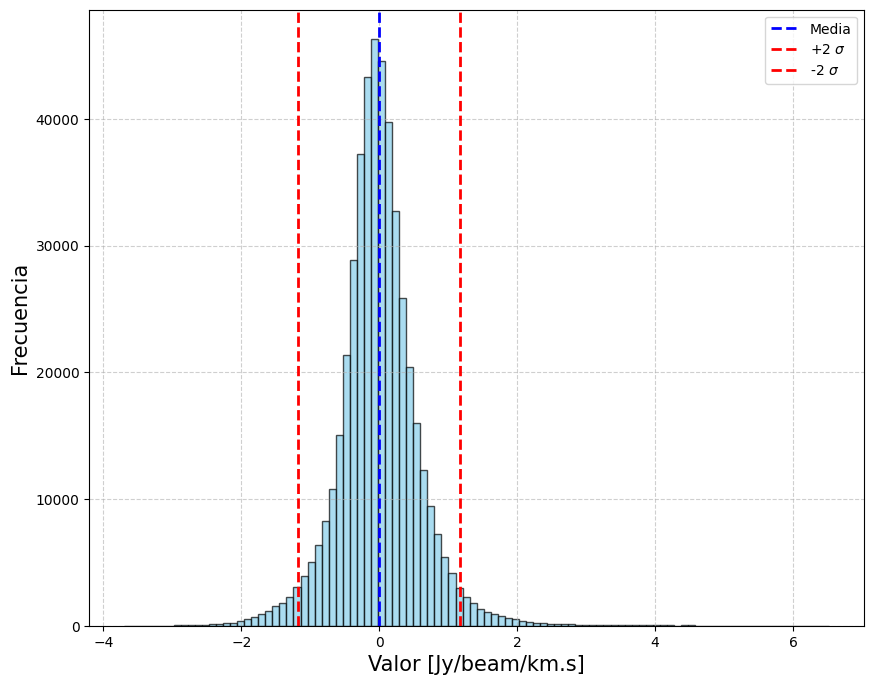

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Histograma con colores mejorados
ax.hist(data_nonan.flatten(), bins=100, color='skyblue', edgecolor='black', alpha=0.7)

# Línea vertical en la media
ax.axvline(data_nonan.mean(), color='blue', linestyle='dashed', linewidth=2, label='Media')

# Línea vertical a una desviación estándar por encima de la media
ax.axvline(data_nonan.mean() + 2*data_nonan.std(), color='red', linestyle='dashed', linewidth=2, label=r'+2 $\sigma$')

# Línea vertical a una desviación estándar por debajo de la media
ax.axvline(data_nonan.mean() - 2*data_nonan.std(), color='red', linestyle='dashed', linewidth=2, label=r'-2 $\sigma$')

# Etiquetas y título mejorados
ax.set_xlabel('Valor [Jy/beam/km.s]', fontsize=15)
ax.set_ylabel('Frecuencia', fontsize=15)

# Añadir leyenda
ax.legend()

# Mejorar la cuadrícula
ax.grid(linestyle='--', alpha=0.6)

plt.show()

Flux Density (Jy/km.s)  Error (Jy/km.s)   Apertura
---------------------- ------------------ --------
    12.325924591674557  1.101872631586892   brazo1
    25.334713645523294  2.182500801917309   brazo2
    31.365670487587927 1.5239918765477642   nucleo
    133.82588751289808  5.617283847424818  galaxia


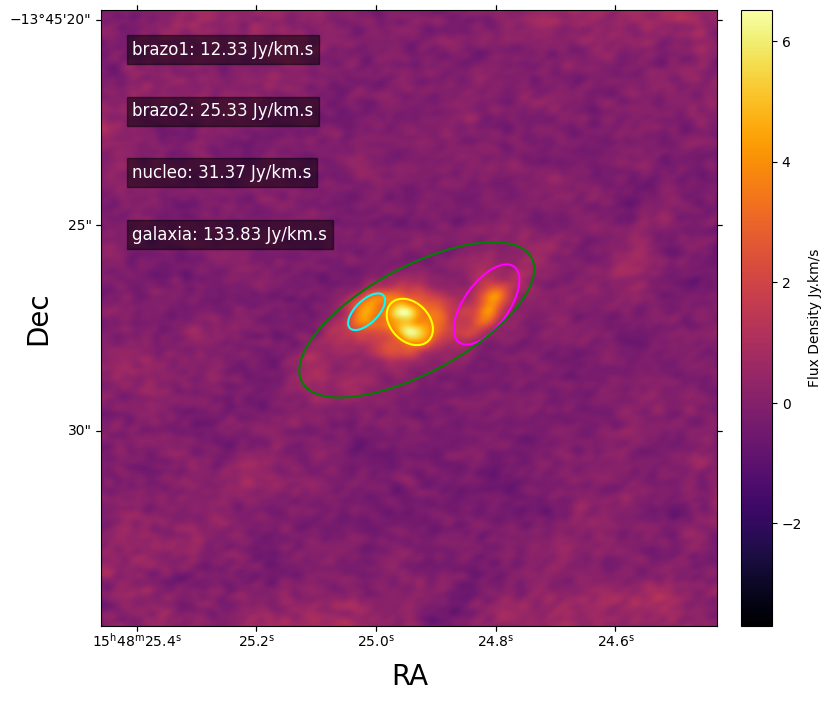

In [56]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

# Cargar el archivo FITS del momento 0 y su WCS
moment0_fits = fits.open('integrated_nt.fits')
moment0_data = moment0_fits[0].data[0]  # Ajuste según sea necesario
moment0_header = moment0_fits[0].header
moment0_wcs = WCS(moment0_header, naxis=2)  # Limitar a 2 dimensiones (RA, Dec)

# Coordenadas y parámetros de las aperturas adicionales desde CARTA
aperturas_coords = [
    {'ra': '15h48m25.015796s', 'dec': '-13d45m27.102814s', 'a': 11.416, 'b': 5.525, 'theta': -315.4623, 'nombre': 'brazo1'},  # Apertura Brazo 1
    {'ra': '15h48m24.815237s', 'dec': '-13d45m26.92748s', 'a': 22.792, 'b': 10.857, 'theta': -305.7784, 'nombre': 'brazo2'},  # Apertura Brazo 2
    {'ra': '15h48m24.943595s', 'dec': '-13d45m27.35119s', 'a': 12.903, 'b': 9.351, 'theta': -45.2664, 'nombre': 'nucleo'},  # Apertura Nucleo
    {'ra': '15h48m24.932063s', 'dec': '-13d45m27.300053s', 'a': 25.786, 'b': 63.570, 'theta': -61.5513, 'nombre': 'galaxia'}  # Apertura Galaxia
]

# Colores para las aperturas
colors = ['cyan', 'magenta', 'yellow', 'green']

# Convertir las coordenadas a píxeles y definir las aperturas elípticas
aperturas = []
for coords in aperturas_coords:
    ra = coords['ra']
    dec = coords['dec']
    
    # Convertir a SkyCoord para manejar correctamente las coordenadas
    skycoord = SkyCoord(ra, dec, frame='icrs')
    x_centroid, y_centroid = moment0_wcs.world_to_pixel(skycoord)
    
    a = coords['a']
    b = coords['b']
    theta = np.radians(coords['theta'])
    
    aperturas.append(EllipticalAperture((x_centroid, y_centroid), a=a, b=b, theta=theta))

# Realizar la fotometría en cada apertura
resultados = []
nombres_aperturas = []
for coords, aperture in zip(aperturas_coords, aperturas):
    phot_table = aperture_photometry(moment0_data, aperture)
    flux = phot_table['aperture_sum'][0]
    num_puntos = aperture.area
    rms = np.std(moment0_data[np.isfinite(moment0_data)])
    flux_density, error = flux_and_rms(flux, rms, num_puntos)
    resultados.append((flux_density, error))
    nombres_aperturas.append(coords['nombre'])

# Guardar los resultados en una tabla de astropy con los nombres de las aperturas
table = Table(rows=resultados, names=('Flux Density (Jy/km.s)', 'Error (Jy/km.s)'))
table['Apertura'] = nombres_aperturas
table.pprint()

# Visualización de la imagen con las aperturas superpuestas
fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': moment0_wcs})
ax.imshow(moment0_data, origin='lower', cmap='inferno')

# Añadir las aperturas con colores diferentes
for aperture, color in zip(aperturas, colors):
    aperture.plot(color=color, lw=1.5, ax=ax)

# Etiquetas con el nombre y el flujo
for i, (coords, (flux_density, _)) in enumerate(zip(aperturas_coords, resultados)):
    ax.text(0.05, 0.95 - i * 0.1, f'{coords["nombre"]}: {flux_density:.2f} Jy/km.s',
            transform=ax.transAxes, color='white', fontsize=12, verticalalignment='top',
            bbox=dict(facecolor='black', alpha=0.5))

ax.set_xlim(300, 600)
ax.set_ylim(300, 600)
ax.set_xlabel('RA', fontsize=20)
ax.set_ylabel('Dec', fontsize=20, labelpad=-1)

# Agregar la barra de color
cax = inset_axes(ax, width="5%", height="100%", loc='center right', bbox_to_anchor=(0.1, 0., 1, 1), bbox_transform=ax.transAxes)
cbar = plt.colorbar(ax.images[0], cax=cax, label='Flux Density Jy.km/s')

plt.show()

# Guardar la tabla en un archivo
#table.write('flux_results_with_names.ecsv', format='ascii.ecsv', overwrite=True)


In [8]:
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from photutils import detect_sources, SourceCatalog, EllipticalAperture, aperture_photometry

def calcular_luminosidad(S, DL, z, nu_obs):
    """
    Calcula la luminosidad de la línea según la ecuación de la diapositiva.

    Parámetros:
    - S: Flujo integrado (Jy km/s)
    - DL: Distancia de luminosidad (Mpc)
    - z: Desplazamiento al rojo (redshift)
    - nu_obs: Frecuencia observada (GHz)

    Retorna:
    - L'_line: Luminosidad de la línea en K km/s pc^2
    - L_line: Luminosidad en L☉ (solares)
    """
    L_prime_line = 3.25e7 * S * (DL**2 / ((1 + z)**3 * nu_obs**2))
    L_line = 1.04e-3 * S * DL**2 * nu_obs
    return L_prime_line, L_line

def calcular_masa_h2(L_prime_line, conversion_factor=0.99, alpha_CO=4):
    """
    Calcula la masa de H2 usando la luminosidad de la línea de CO(2-1).

    Parámetros:
    - L_prime_line: Luminosidad de la línea CO(2-1) en K km/s pc^2
    - conversion_factor: Factor de conversión de L'_CO(2-1) a L'_CO(1-0) para QSO
    - alpha_CO: Factor de conversión (aproximadamente 4 M☉/K km/s pc^2 para QSO)

    Retorna:
    - Masa de H2 en M☉ (masas solares)
    """
    L_prime_CO_10 = L_prime_line * conversion_factor
    M_H2 = alpha_CO * L_prime_CO_10
    return M_H2


In [9]:
# Parámetros conocidos
z = 0.024807  # Redshift proporcionado
nu_obs = 224.674  # Frecuencia observada en GHz (CO(2-1))

# Calcular la distancia de luminosidad usando Astropy
DL = cosmo.luminosity_distance(z).value  # en Mpc

# Supongamos que ya tienes los resultados previos en una tabla `table`
# Añadir columnas para luminosidad y masa de H2
L_prime_line_values = []
M_H2_values = []

for row in table:
    flux_density = row['Flux Density (Jy/km.s)']
    L_prime_line, _ = calcular_luminosidad(flux_density, DL, z, nu_obs)
    M_H2 = calcular_masa_h2(L_prime_line)
    
    L_prime_line_values.append(L_prime_line)
    M_H2_values.append(M_H2)

# Añadir los valores calculados a la tabla
table['L_prime_line (K km/s pc^2)'] = L_prime_line_values
table['M_H2 (M☉)'] = M_H2_values
for M_H2, nombre in zip(M_H2_values, nombres_aperturas):
    print(f"{nombre}: Masa de H2 = {M_H2:.2e} M☉")

brazo1: Masa de H2 = 3.66e+08 M☉
brazo2: Masa de H2 = 7.53e+08 M☉
nucleo: Masa de H2 = 9.32e+08 M☉
galaxia: Masa de H2 = 3.98e+09 M☉


In [10]:
import numpy as np

# Función para convertir arcosegundos a radianes
def arcsec_to_radians(arcsec):
    return arcsec * np.pi / (180 * 3600)

# Calcular el área en radianes cuadrados para cada apertura
areas_radianes = []
for coords in aperturas_coords:
    a_radians = arcsec_to_radians(coords['a'])
    b_radians = arcsec_to_radians(coords['b'])
    area_radianes = np.pi * a_radians * b_radians
    areas_radianes.append(area_radianes)

# Convertir el área a kpc^2
areas_kpc2 = [(area_radianes * (DL * 1000)**2) for area_radianes in areas_radianes]

# Calcular la densidad superficial de H2
densidades_superficiales_H2 = [M_H2 / area_kpc2 for M_H2, area_kpc2 in zip(M_H2_values, areas_kpc2)]

# Agregar las densidades superficiales a la tabla
table['Surface Density H2 (M☉/kpc^2)'] = densidades_superficiales_H2

for densidad, nombre in zip(densidades_superficiales_H2, nombres_aperturas):
    print(f"{nombre}: Densidad superficial de H2 = {densidad:.2e} M☉/kpc^2")


brazo1: Densidad superficial de H2 = 6.27e+06 M☉/kpc^2
brazo2: Densidad superficial de H2 = 3.28e+06 M☉/kpc^2
nucleo: Densidad superficial de H2 = 8.34e+06 M☉/kpc^2
galaxia: Densidad superficial de H2 = 2.62e+06 M☉/kpc^2


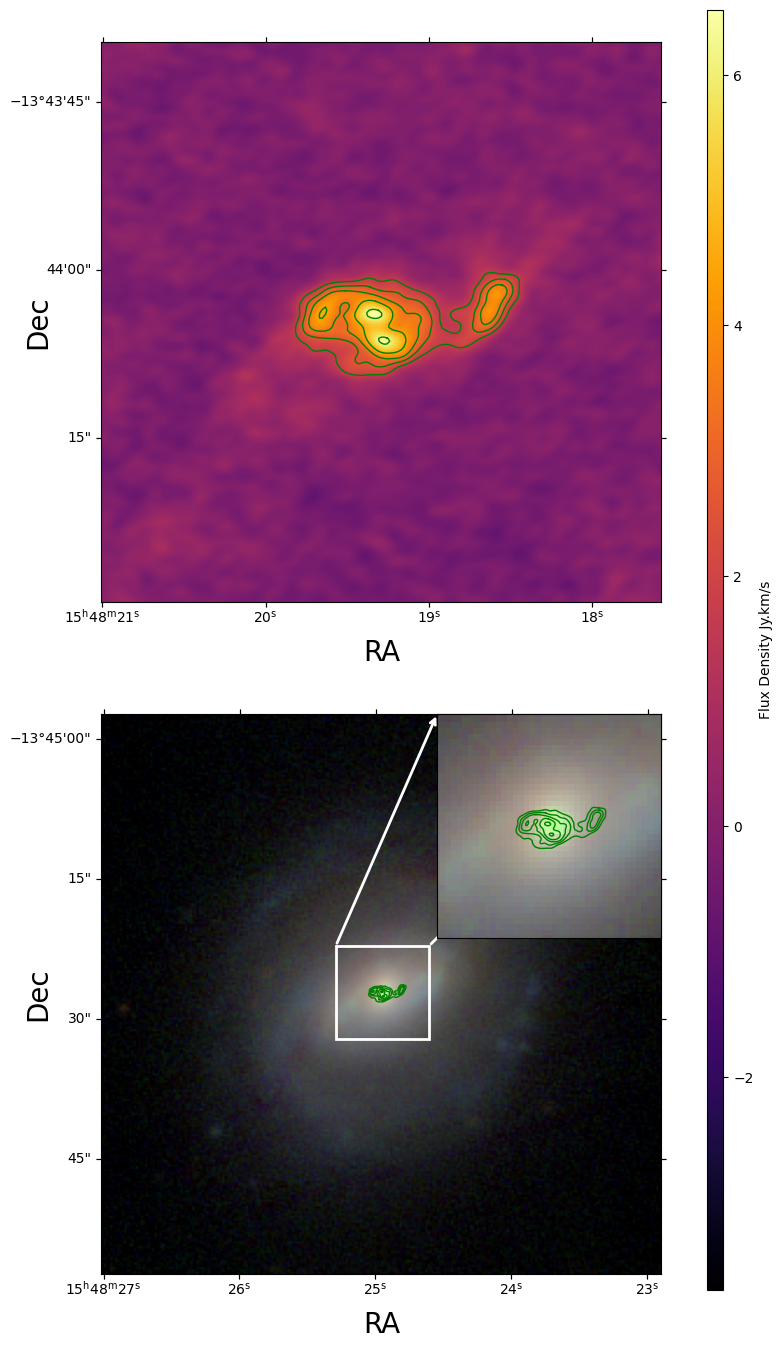

In [68]:
# Cargar el archivo FITS del momento 0 y su WCS
moment0_fits = fits.open('integrated_nt.fits')
moment0_data = moment0_fits[0].data[0]  # Ajuste según sea necesario
moment0_header = moment0_fits[0].header
moment0_wcs = WCS(moment0_header, naxis=2)  # Limitar a 2 dimensiones (RA, Dec)

# Detectar fuentes en la imagen del momento 0
std_3 =2*np.std(moment0_data[np.isfinite(moment0_data)])
segm = detect_sources(moment0_data, 1 * std_3, npixels=100)

# Crear un catálogo de fuentes
catalog = SourceCatalog(moment0_data, segm)

# Identificar la fuente más fuerte
max_flux_index = np.argmax(catalog.segment_flux)
strongest_source = catalog[max_flux_index]

# Extraer la región de la fuente más fuerte
strongest_mask = segm.data == strongest_source.label
strongest_data = moment0_data * strongest_mask

# Calcular los niveles de contornos basados en los percentiles para la fuente más fuerte
percentiles = [20, 50, 70, 90, 99]
levels = np.percentile(strongest_data[strongest_mask], percentiles)

# Cargar las imágenes RGB y su WCS
wcs_rgb = WCS(fits.open('cutout_rings.v3.skycell.1024.055.stk.r.unconv.fits')[0].header)
r = fits.open('cutout_rings.v3.skycell.1024.055.stk.r.unconv.fits')[0].data
g = fits.open('cutout_rings.v3.skycell.1024.055.stk.g.unconv.fits')[0].data
i = fits.open('cutout_rings.v3.skycell.1024.055.stk.i.unconv.fits')[0].data

# Normalizar las bandas individualmente
r = r / np.mean(r)
g = g / np.mean(g)
i = i / np.mean(i)

# Crear la imagen RGB
rgb = make_lupton_rgb(i, r, g)

# Configurar el plot con WCS de la imagen RGB y la imagen del momento 0
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(8, 16), subplot_kw={'projection': wcs_rgb})

# Mostrar la imagen RGB en el primer subplot
ax1.imshow(rgb, origin='lower')

# Crear el inset de la imagen ampliada
axins = inset_axes(ax1, width="40%", height="40%", loc='upper right', borderpad=0)

# Mostrar la imagen ampliada en el inset
zoom_level = 20  # Nivel de zoom
axins.imshow(rgb, origin='lower')

# Ajustar la posición del zoom
center_x, center_y = 120, 120  # Mueve el centro del zoom a la izquierda
axins.set_xlim(center_x - zoom_level, center_x + zoom_level)
axins.set_ylim(center_y - zoom_level, center_y + zoom_level)
axins.set_xticks([])
axins.set_yticks([])

# Dibujar los contornos en la imagen RGB y en el inset
for level in levels:
    contours = find_contours(strongest_data, level=level)
    for contour in contours:
        pix_coords = moment0_wcs.pixel_to_world(contour[:, 1], contour[:, 0])
        new_coords = wcs_rgb.world_to_pixel(pix_coords)
        ax1.plot(new_coords[0], new_coords[1], color='green', linewidth=1)
        axins.plot(new_coords[0], new_coords[1], color='green', linewidth=1)

# Agregar un rectángulo en la región donde se realiza el zoom
rect = Rectangle((center_x - zoom_level, center_y - zoom_level),
                 2 * zoom_level, 2 * zoom_level, edgecolor='white', facecolor='none', lw=2)
ax1.add_patch(rect)

# Dibujar flechas desde el rectángulo hacia el inset
arrowprops = dict(arrowstyle="<-", color='white', lw=2)
ax1.annotate('', xy=(center_x + zoom_level, center_y + zoom_level), 
             xytext=(1, 1), textcoords=axins.transAxes, arrowprops=arrowprops)
ax1.annotate('', xy=(center_x - zoom_level, center_y + zoom_level), 
             xytext=(0, 1), textcoords=axins.transAxes, arrowprops=arrowprops)

ax1.set_xlabel('RA', fontsize=20)
ax1.set_ylabel('Dec', fontsize=20, labelpad=-1)

# Mostrar la imagen del momento 0 en el segundo subplot
ax2.imshow(moment0_data, origin='lower', cmap='inferno')

# Dibujar los mismos contornos en la imagen del momento 0
for level in levels:
    contours = find_contours(strongest_data, level=level)
    for contour in contours:
        ax2.plot(contour[:, 1], contour[:, 0], color='green', linewidth=1)

ax2.set_xlabel('RA', fontsize=20)
ax2.set_ylabel('Dec', fontsize=20, labelpad=-1)
ax2.set_xlim(350, 550)
ax2.set_ylim(350, 550)

# Añadir un colorbar para la imagen del momento 0
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
plt.colorbar(ax2.imshow(moment0_data, origin='lower', cmap='inferno'), cax=cax, label='Flux Density Jy.km/s')

plt.tight_layout()
plt.show()


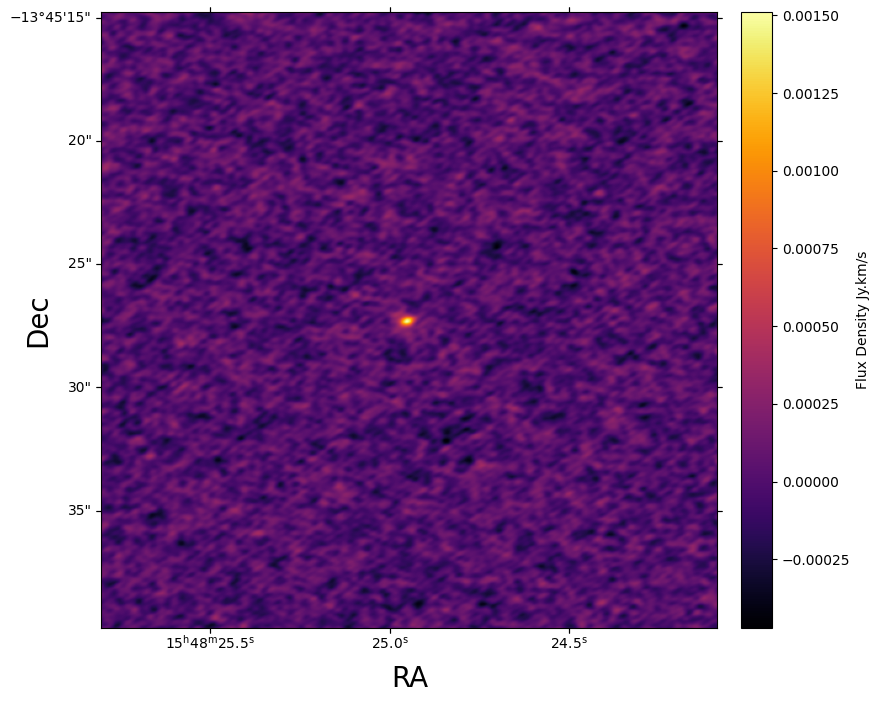

In [62]:
# Hacer un plot de continue.fits

continue_fits = fits.open('continue.fits')
continue_data = continue_fits[0].data
continue_header = continue_fits[0].header

wcs_continue = WCS(continue_header, naxis=2)

# Configurar los ejes con WCS para la primera imagen
fig, ax = plt.subplots(subplot_kw={'projection': wcs_continue}, figsize=(8, 8))

# Mostrar la imagen con coordenadas WCS
ax.imshow(continue_data[0], origin='lower', cmap='inferno')
ax.set_xlabel('RA', fontsize=20)
ax.set_ylabel('Dec', fontsize=20, labelpad=-1)
ax.set_xlim(200, 700)
ax.set_ylim(200, 700)

# Mostrar colorbar
cax = inset_axes(ax, width="5%", height="100%", loc='center right', bbox_to_anchor=(0.1, 0., 1, 1), bbox_transform=ax.transAxes)
cbar = plt.colorbar(ax.images[0], cax=cax, label='Flux Density Jy.km/s')


plt.show()